# A Few Practical Thoughts on Supervised Learning
> __Caution__: I am newbie for Kaggle and also real-world machine learning problems. So this notebook contains kind of "failure story" and some questions to you, ladies and gentlemen. I will appreciate your answer!

## Motivation
There are many precious notebooks in Kaggle, (although I have read only a few of most-voted ones), and many of them just used categorical variables, not using dummy variables. And then the comment pointing the use of dummies also got many votes. This is my motivation; how the dummies improve the model?

References so far:
* https://www.kaggle.com/startupsci/titanic-data-science-solutions
* https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
* https://www.kaggle.com/ash316/eda-to-prediction-dietanic

Since I think that other similar topics could be included here, below are the main questions:
* Nominal variables vs. Dummies
* Does scaling really have effects?  
  Then which variable is appropriate to be applied?
* How much does the cross-validation improve the model accuracy?
* Is the regularization really helpful for the generalization?

Here the only logistic regression is used for the training method and there is no comparison among various ones, simply because I do not know much detail of other sophisticated methods. Logistic regression is chosen since it is simple and easy to understand, for me.

In [1]:
import re

import scipy
import pandas
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## The Copied and Pasted Contents from Kaggle

FYI, the dataset is from Kaggle. For those who see this outside Kaggle, below is the copied from https://www.kaggle.com/c/titanic.
### Data Description
#### Overview
The data has been split into two groups:
* training set (train.csv)
* test set (test.csv)

__The training set__ should be used to build your machine learning models. For the training set, we provide the outcome (also known as the "ground truth") for each passenger. Your model will be based on "features" like passengers’ gender and class. You can also use [feature engineering](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data) to create new features.

__The test set__ should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include __gender_submission.csv__, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

#### Data Dictionary

Variable | Definition | Key
---|---|---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex |
Age | Age in years |
sibsp | # of siblings / spouses aboard the Titanic |
parch | # of parents / children aboard the Titanic |
ticket | Ticket number |
fare | Passenger fare |
cabin | Cabin number |
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes

* __pclass__: A proxy for socio-economic status (SES)  
  1st = Upper  
  2nd = Middle  
  3rd = Lower
* __age__: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* __sibsp__: The dataset defines family relations in this way...  
  Sibling = brother, sister, stepbrother, stepsister  
  Spouse = husband, wife (mistresses and fiancés were ignored)
* __parch__: The dataset defines family relations in this way...  
  Parent = mother, father  
  Child = daughter, son, stepdaughter, stepson  
  Some children travelled only with a nanny, therefore parch=0 for them.

# Part 1. Sightseeing
Here I will do almost the same as other notebooks do. I would like to check the training data where the preprocessing is necessary. I will also follow some preprocessing strategies from other notebooks (e.g. a strategy to fill `NA`s for `Age`).

Let's check the data type first, and see the first few lines.

In [2]:
dftrain_full = pandas.read_csv('../data/titanic/train.csv')
dftrain_full.info()
dftrain_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Summary statistics next, for numerical and categorical variables respectively.

In [3]:
dftrain_full.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
dftrain_full.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Renouf, Mr. Peter Henry",male,1601,G6,S
freq,1,577,7,4,644


And check the missing data.

In [5]:
print('is NA?\n', dftrain_full.isna().sum(), '\n')
print('is NULL?\n', dftrain_full.isnull().sum())

is NA?
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

is NULL?
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Variables
> Q. Since the goal of this notebook is to compare the effect of some practices, I try to keep the data as raw as possible. For instance, I won't make a new variable `Family` by adding `SibSp` and `Parch`. Any thoughts will be welcome!

From the simple glance above, I figure the variables as...

1. Numerical variables:
  * Age with missing data  
    We fill the missing data with the mean w.r.t. their Title group
  * Sibsp
  * Parch
  * Fare (Note that there are missing data in the test set!)
1. Ordinal variables:
  * Pclass
1. Nominal variables: All the nominal converted to their K-1 dummies.
  * Sex (`female` or `male`)
  * Title from Name (`Master`, `Miss`, `Mrs`, `Mr`, `Rare`)
  * Embarked (`Q`, `S`, `C`): Missing data are filled with `S`, the mode of the variable.
1. Discarded variables: I couldn't convince myself on how to use it.
  * PassengerId
  * Name
  * Ticket
  * Cabin
  
Below is the function that extracts Title information from Name column, stolen from other famous Kaggle notebooks.

In [6]:
def get_title(name):
    regex_title = re.search(' ([a-zA-Z]+)\.', name)
    if regex_title:
        return regex_title.group(1)
    return ''

## Outline for Simulations

1. No regularization
  1. Dummy variables, or Not
  1. Scaling only the numeric, or scaling all, or not at all
1. Regularization with cross-validation
  1. Dummy variables, or Not
  1. Scaling only the numeric, or scaling all, or not at all

It will be a quite repeated work! To simulate these with less code, below are the universal functions for preprocessing and training. It's quite long but can be used conveniently.

In [7]:
def preprocess(df: pandas.DataFrame,
               dfgroup_age: pandas.DataFrame=None,
               dfgroup_fare: pandas.DataFrame=None,
               df_mean: pandas.DataFrame=None,
               df_std: pandas.DataFrame=None,
               use_dummies: bool=True,
               standardized_columns=None):
    """Preprocessing function
    
    if only `df` is supplied, it regards `df` as the training data,
    otherwise as the test data.
    
    This function prefers "inplace" operation,
    so I will input a copy of a dataframe; e.g. `preprocess(df.copy())`.
    """
    df['Title'] = df['Name'].apply(get_title)
    df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                         'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
                        'Rare',
                        inplace=True)
    df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'},
                        inplace=True)

    df = pandas.concat([df, pandas.get_dummies(df['Sex'],
                                               prefix='Sex')],
                       axis=1)

    df['Embarked'].fillna('S', inplace=True)

    if use_dummies is True:
        df = pandas.concat(
            [df, pandas.get_dummies(df['Title'], prefix='Title')],
            axis=1
        )
        df = pandas.concat(
            [df, pandas.get_dummies(df['Embarked'], prefix='Embarked')],
            axis=1
        )
        dropped_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin',
                        'Sex', 'Sex_male', 'Embarked', 'Embarked_C',
                        'Title', 'Title_Rare']
    else:
        df['Title'].replace({'Master': 1, 'Miss': 2,
                             'Mrs': 3, 'Mr': 4, 'Rare': 5},
                            inplace=True)
        df['Title'].fillna(0, inplace=True)
        df['Embarked'].replace({'S': 0, 'Q': 1, 'C': 2}, inplace=True)
        dropped_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin',
                        'Sex', 'Sex_male']

    if dfgroup_age is None:
        # Only at training
        dfgroup_age = df.groupby('Title')['Age'].mean()
    for title, age in dfgroup_age.items():
        df.loc[(df.Age.isnull())&(df.Title == title), 'Age'] = age

    if dfgroup_fare is None:
        # Only at training
        dfgroup_fare = df.groupby('Title')['Fare'].mean()
    for title, fare in dfgroup_fare.items():
        df.loc[(df.Fare.isnull())&(df.Title == title), 'Fare'] = fare

    df.drop(columns=dropped_cols, inplace=True)
    
    # Generate mean and std, then standardize the specifed columns
    if standardized_columns is not None:
        if df_mean is None:
            df_mean = df[standardized_columns].mean()
        if df_std is None:
            df_std = df[standardized_columns].std()
        df[standardized_columns] -= df_mean
        df[standardized_columns] /= df_std
    return df, dfgroup_age, dfgroup_fare, df_mean, df_std

# Part 2. No Regularization, No CV
Without the duty of concerning the regularization parameter, the training procedure gets simpler.

> Q. Honestly I am not sure to omit CV here.  
> What would be the merit of CV for such simpler models, having no regularization parameters?

## Split the Data for Validation

The raw data are split into training and validation set for assessment of the model.

In [8]:
dftrain, dfval = sklearn.model_selection.train_test_split(
    dftrain_full,
    test_size=0.3,
    random_state=0,
    stratify=dftrain_full['Survived'],
)

## 1. Dummies or Not

In [9]:
tr1Xy, tr1group_age, tr1group_fare, _, _ = preprocess(dftrain.copy())
tr2Xy, tr2group_age, tr2group_fare, _, _ = preprocess(dftrain.copy(),
                                                      use_dummies=False)
tr1X = tr1Xy.drop(columns=['Survived'])
tr1Y = tr1Xy['Survived']
tr2X = tr2Xy.drop(columns=['Survived'])
tr2Y = tr2Xy['Survived']

# tr1Xy.head()
# tr2Xy.head()

In [10]:
# Prepare the validation data
val1X, _, _, _, _ = preprocess(dfval.copy(), tr1group_age, tr1group_fare)
val1Y = val1X['Survived']
val1X.drop(columns=['Survived'], inplace=True)

val2X, _, _, _, _ = preprocess(dfval.copy(), tr2group_age, tr2group_fare,
                               use_dummies=False)
val2Y = val2X['Survived']
val2X.drop(columns=['Survived'], inplace=True)

# val1X.head()
# val2X.head()

### Training and Validation

Let's apply the simple logistic regression, and check the accuracy on the validation set.

In [11]:
# Set a very large value for the regularization parameter
logistic1 = LogisticRegression(penalty='l2', C=1e50)
logistic1.fit(tr1X, tr1Y)
logistic1_pred = logistic1.predict(val1X)
val1_accuracy = (logistic1_pred != val1Y.values).mean()

logistic2 = LogisticRegression(penalty='l2', C=1e50)
logistic2.fit(tr2X, tr2Y)
logistic2_pred = logistic2.predict(val2X)
val2_accuracy = (logistic2_pred != val2Y.values).mean()
print('Validation accuracy (Dummies):', 1-val1_accuracy)
print('Validation accuracy (No dummies):', 1-val2_accuracy)

Validation accuracy (Dummies): 0.8283582089552239
Validation accuracy (No dummies): 0.8208955223880597


Oh, dummies do some help.

## 2. Standardize or Not

I will use dummy variables from the above results.

I found [there](https://www.quora.com/How-bad-is-it-to-standardize-dummy-variables) that the effect of standardization on dummy variables may be different case-by-case. So the goal is to check that effect for this Titanic data set. Therefore I conduct the experiment to standardize
* nothing (already computed above),
* only the numeric
* all (the numeric + dummies)

Then the similar training-and-validation cycle goes on.

In [12]:
columns_numeric = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
columns_all = columns_numeric + [
    'Sex_female', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
    'Embarked_Q', 'Embarked_S',
]

(tr3Xy,
 tr3group_age,
 tr3group_fare,
 tr3mean,
 tr3std) = preprocess(dftrain.copy(),
                      standardized_columns=columns_numeric)
(tr4Xy,
 tr4group_age,
 tr4group_fare,
 tr4mean,
 tr4std) = preprocess(dftrain.copy(),
                      standardized_columns=columns_all)

tr3X = tr3Xy.drop(columns=['Survived'])
tr3Y = tr3Xy['Survived']
tr4X = tr4Xy.drop(columns=['Survived'])
tr4Y = tr4Xy['Survived']

# print('Really standardized?\n', tr3Xy.mean(), '\n', tr3Xy.std())
# print('Really standardized?\n', tr4Xy.mean(), '\n', tr4Xy.std())

In [13]:
# Prepare the validation data
val3X, _, _, _, _ = preprocess(dfval.copy(),
                               tr3group_age, tr3group_fare,
                               tr3mean, tr3std,
                               standardized_columns=columns_numeric)
val4X, _, _, _, _ = preprocess(dfval.copy(),
                               tr4group_age, tr4group_fare,
                               tr4mean, tr4std,
                               standardized_columns=columns_all)

val3Y = val3X['Survived']
val3X.drop(columns=['Survived'], inplace=True)
val4Y = val4X['Survived']
val4X.drop(columns=['Survived'], inplace=True)

# val3X.head()
# val4X.head()

In [14]:
logistic3 = LogisticRegression(penalty='l2', C=1e50)
logistic3.fit(tr3X, tr3Y)
logistic3_pred = logistic3.predict(val3X)
val3_accuracy = (logistic3_pred != val3Y.values).mean()

logistic4 = LogisticRegression(penalty='l2', C=1e50)
logistic4.fit(tr4X, tr4Y)
logistic4_pred = logistic4.predict(val4X)
val4_accuracy = (logistic4_pred != val4Y.values).mean()
print('Validation accuracy (Standardized numeric variables):', 1-val3_accuracy)
print('Validation accuracy (All standardized):', 1-val4_accuracy)

Validation accuracy (Standardized numeric variables): 0.8283582089552239
Validation accuracy (All standardized): 0.8283582089552239


Unfortunately, the standardization shows no effect here. So I continue with regularization.

# Part 3. Regularization with Cross-Validation

So far our experiments did not give any implication on standardization. However I continue to test it with more general situation, by adding the regularization.

I use the cross-validation technique for catching the best regularization parameter $\lambda$. I leave the reference from scikit-learn [here](http://scikit-learn.org/stable/modules/cross_validation.html) and [there](http://scikit-learn.org/stable/modules/grid_search.html).

## 1. Dummies or Not

In [15]:
tr5Xy, _, _, _, _ = preprocess(dftrain_full.copy())
tr6Xy, _, _, _, _ = preprocess(dftrain_full.copy(), use_dummies=False)

tr5X = tr5Xy.drop(columns=['Survived'])
tr5y = tr5Xy['Survived']
tr6X = tr6Xy.drop(columns=['Survived'])
tr6y = tr6Xy['Survived']

logistic5 = LogisticRegressionCV(penalty='l2', Cs=100, cv=10)
logistic6 = LogisticRegressionCV(penalty='l2', Cs=100, cv=10)

logistic5.fit(tr5X, tr5y)
logistic6.fit(tr6X, tr6y)

val5accuracy = logistic5.scores_[1]
val6accuracy = logistic6.scores_[1]

Text(0.5,1,'LogisticRegressionCV')

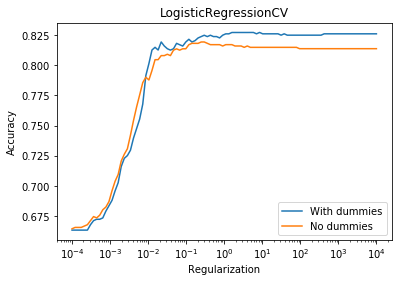

In [16]:
# Plot
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1, 1, 1)
ax1.semilogx(logistic5.Cs_, val5accuracy.mean(axis=0), label='With dummies')
ax1.semilogx(logistic6.Cs_, val6accuracy.mean(axis=0), label='No dummies')
ax1.set_xlabel('Regularization')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title('LogisticRegressionCV')

Again, dummies do good.

## 2. Standardize or Not

Since it is confirmed that dummies do help, I will use dummy variables for the next experiment.

In [17]:
# https://stackoverflow.com/questions/20625582
pandas.options.mode.chained_assignment = None


class CustomScaler(sklearn.base.TransformerMixin):
    """This standardizes only specified variables.
    Reference: https://stackoverflow.com/questions/37685412
    """
    def __init__(self, columns):
        self.columns = columns
        self.scaler = sklearn.preprocessing.StandardScaler()
        
    def fit(self, X, y):
        self.scaler.fit(X[self.columns], y)
        return self
    
    def transform(self, X):
        X.loc[:, self.columns] = self.scaler.transform(X[self.columns])
        return X

In [18]:
# Only the numeric standardized
pipe7 = sklearn.pipeline.make_pipeline(
    CustomScaler(columns=['Age', 'SibSp', 'Parch', 'Fare']),
    LogisticRegressionCV(penalty='l2', Cs=100, cv=10)
)
# All standardized
pipe8 = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    LogisticRegressionCV(penalty='l2', Cs=100, cv=10)
)
tr7Xy, _, _, _, _ = preprocess(dftrain_full.copy())
tr7X = tr7Xy.drop(columns=['Survived'])
tr7y = tr7Xy['Survived']

pipe7.fit(tr7X, tr7y)
pipe8.fit(tr7X, tr7y)

# Access LogisticRegressionCV classes from pipelines
logistic7 = pipe7.steps[1][1]
logistic8 = pipe8.steps[1][1]

# Get the raw CV results (cv x Cs ndarrays)
val7accuracy = logistic7.scores_[1]
val8accuracy = logistic8.scores_[1]

Text(0.5,1,'LogisticRegressionCV with Dummies')

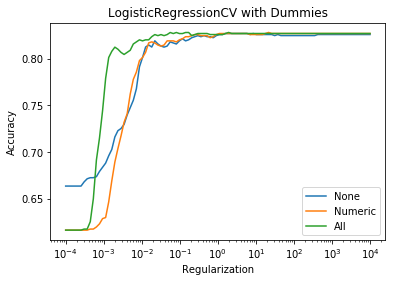

In [19]:
# Plot
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.semilogx(logistic5.Cs_, val5accuracy.mean(axis=0), label='None')
ax2.semilogx(logistic7.Cs_, val7accuracy.mean(axis=0), label='Numeric')
ax2.semilogx(logistic8.Cs_, val8accuracy.mean(axis=0), label='All')
ax2.set_xlabel('Regularization')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('LogisticRegressionCV with Dummies')

I see from this figure that "Standardize-all" strategy is better than others.

# Final Tests

I will pass the final test data to every model that trained so far. To list them,
* `logistic1`: No regularization, no CV, with dummies, no standardization
* `logistic2`: No regularization, no CV, no dummies, no standardization
* `logistic3`: No regularization, no CV, with dummies, standardized numeric variables
* `logistic4`: No regularization, no CV, with dummies, all standardized
* `logistic5`: Regularization with CV, with dummies, no standardization
* `logistic6`: Regularization with CV, no dummies, no standardization
* `pipe7`: Regularization with CV, with dummies, standardized numeric variables
* `pipe8`: Regularization with CV, with dummies, all standardized

In [20]:
# Read the test data
dftest = pandas.read_csv('../data/titanic/test.csv')

# Generating-csv function for the submission
def submit(dftest: pandas.DataFrame, pred: scipy.ndarray, csv_fname: str)->None:
    dfsubmit = pandas.DataFrame(data={'PassengerId': dftest['PassengerId'],
                                      'Survived': pred})
    dfsubmit.to_csv(f'../data/titanic/{csv_fname}', index=False)

In [21]:
# The first round, plain logistic regression models without CV
te1X, _, _, _, _ = preprocess(dftest.copy(), tr1group_age, tr1group_fare)
pred1 = logistic1.predict(te1X)
submit(dftest, pred1, 'logistic1.csv')

te2X, _, _, _, _ = preprocess(dftest.copy(), tr2group_age, tr2group_fare,
                              use_dummies=False)
pred2 = logistic2.predict(te2X)
submit(dftest, pred2, 'logistic2.csv')

te3X, _, _, _, _ = preprocess(dftest.copy(),
                              tr3group_age, tr3group_fare,
                              tr3mean, tr3std,
                              standardized_columns=columns_numeric)
pred3 = logistic3.predict(te3X)
submit(dftest, pred3, 'logistic3.csv')

te4X, _, _, _, _ = preprocess(dftest.copy(),
                              tr4group_age, tr4group_fare,
                              tr4mean, tr4std,
                              standardized_columns=columns_all)
pred4 = logistic4.predict(te4X)
submit(dftest, pred4, 'logistic4.csv')

In [22]:
# The second round, regularization with CV
te5X, _, _, _, _ = preprocess(dftest.copy())
pred5 = logistic5.predict(te5X)
submit(dftest, pred5, 'logistic5.csv')

te6X, _, _, _, _ = preprocess(dftest.copy(), use_dummies=False)
pred6 = logistic6.predict(te6X)
submit(dftest, pred6, 'logistic6.csv')

pred7 = pipe7.predict(te5X)
submit(dftest, pred7, 'logistic7.csv')

pred8 = pipe8.predict(te5X)
submit(dftest, pred8, 'logistic8.csv')

> Q. Coding such experiments makes me duplicated works. I think it is not a fault of scikit-learn, and it seems quite inevitable. I am curious of how others do such things.

# Results

Note that the demo `gender_submission.csv` provided by Kaggle gave me 76.555%.

 | Plain | Regularization
---| --- | ---
No dummies, No std | 76.555% | 76.076%
Dummies, No std | 78.947% | 78.468%
Dummies, Numeric std | 78.947% | 78.468%
Dummies, All std | 78.947% | 78.468%


## What I learned

Feeling bad to say, but I couldn't say any implication from this experiments.

* Dummies surely help to make the model better.
* I need to compare with more complex models!  
  I am not sure but simpler models may be robust on scaling or standardization.  
  > Q. Really?
* Plotting with CV makes me feel comfortable to visually compare some models.  
  But from the final test results, I may say that it does no help sometimes.

Any feedback, suggestion, pointing my mistakes is welcome.